**Set Environment**

In [1]:
suppressMessages(suppressWarnings(source("config.R")))

You are on Duke Server: DCC
BASE DIRECTORY:     /work/kk319 
WORK DIRECTORY:     /work/kk319/out/CombEffect_STARR 
LOG  DIRECTORY:     /work/kk319/out/CombEffect_STARR/log 
PATH OF SOURCE:     /work/kk319/source 
PATH OF EXECUTABLE: /work/kk319/exe 
PATH OF ANNOTATION: /work/kk319/annotation 


## Import library size

In [2]:
get_sample = function(idn_sample){
    idn = idn_sample
    idn = str_replace(
        string = idn, 
        pattern = "Input[0-9]", 
        replacement = "Input")
    idn = str_replace(
        string = idn, 
        pattern = "TFX[0-9]_", 
        replacement="TFX_")
    return(idn)
}

In [3]:
fdiry = file.path(FD_WRK, "source")
fname = "library_size.txt"
fpath = file.path(fdiry, fname)

ctypes = c(col_integer(), col_character())
cnames = c("Size", "Fpath")
dat_lib = read_tsv(fpath, col_types=ctypes, col_names = cnames)
dat_lib = dat_lib %>% 
    mutate(Sample = tools::file_path_sans_ext(basename(Fpath))) %>%
    mutate(Group = get_sample(Sample))
dat_lib = dat_lib %>% dplyr::select(Size, Sample, Group)
head(dat_lib, 10)

Size,Sample,Group
18666630,Input1,Input
20167924,Input2,Input
23280988,Input3,Input
19003938,Input4,Input
15325016,Input5,Input
48376253,TFX2_AZD2906,TFX_AZD2906
52542517,TFX2_AZD9567,TFX_AZD9567
43646484,TFX2_CORT108297,TFX_CORT108297
41732268,TFX2_CpdA,TFX_CpdA
43844606,TFX2_DMSO,TFX_DMSO


## Import data

In [4]:
### set samples
Samples=c(
    paste0("Input", 1:5),
    paste0("TFX",   2:5, "_DMSO"),
    paste0("TFX",   2:5, "_Dex")
)

### get all motifs
fpaths = list.dirs("/work/kk319/out/CombEffect_STARR/annotation_fragment/Input1")
motifs = basename(fpaths)
motifs = grep(pattern = paste(c(Samples, "ipynb"), collapse="|"),
     x       = motifs, 
     invert  = TRUE,
     value   = TRUE)

print(length(motifs))
print(head(motifs))

[1] 272
[1] "AHR"   "AIRE"  "AP1_1" "AP1_2" "ARI5A" "ARI5B"


In [5]:
ctypes = c(col_character(), col_integer(), col_integer(), col_integer(),
           col_character(), col_integer(), col_integer(),
           col_character(), col_double(),  col_integer())
cnames = c("Chrom_Frag", "Start_Frag", "End_Frag", "Count_Frag",
           "Chrom_MTF",  "Start_MTF",  "End_MTF",
           "Motif", "Score", "Overlap")
fname = "target_PER1.bed"

### import each annotated fragment file
lst_dat = lapply(motifs, function(motif){
    lst = lapply(Samples, function(sam){
        ### get file
        fdiry = file.path(FD_WRK, "annotation_fragment", sam, motif)
        fpath = file.path(fdiry, fname)
        
        ### import data
        dat = read_tsv(fpath, col_types=ctypes, col_names=cnames)
        dat$Sample = sam
        return(dat)
    })
    dat = bind_rows(lst)
    return(dat)
})
names(lst_dat) = motifs

### filter out empty files
fun = function(dat){(nrow(dat) != 0) & (!is.null(dat))}
lst_dat = Filter(fun, lst_dat)

### change motif names
lst_dat = lapply(lst_dat, function(dat){
    dat$Motif = str_replace_all(
        string  = dat$Motif, 
        pattern = "/", 
        replacement = "_")
    return(dat)
})

Warning message:
“`data_frame()` was deprecated in tibble 1.1.0.
Please use `tibble()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”

In [6]:
lst_dat %>% lapply(head, 3) %>% head(3)

Chrom_Frag,Start_Frag,End_Frag,Count_Frag,Chrom_MTF,Start_MTF,End_MTF,Motif,Score,Overlap,Sample
chr17,8150329,8151343,1,chr17,8151284,8151290,AHR,7.9331,6,Input1
chr17,8150402,8151376,1,chr17,8151284,8151290,AHR,7.9331,6,Input1
chr17,8150410,8151356,1,chr17,8151284,8151290,AHR,7.9331,6,Input1
Chrom_Frag,Start_Frag,End_Frag,Count_Frag,Chrom_MTF,Start_MTF,End_MTF,Motif,Score,Overlap,Sample
chr17,8158206,8159259,1,chr17,8159244,8159259,AIRE,7.5632,15,Input1
chr17,8158571,8159503,1,chr17,8159244,8159259,AIRE,7.5632,15,Input1
chr17,8158876,8159981,1,chr17,8159244,8159259,AIRE,7.5632,15,Input1
Chrom_Frag,Start_Frag,End_Frag,Count_Frag,Chrom_MTF,Start_MTF,End_MTF,Motif,Score,Overlap,Sample
chr17,8148117,8149012,1,chr17,8148425,8148433,AP1_1,6.7321,8,Input1
chr17,8148117,8149012,1,chr17,8148917,8148925,AP1_1,8.0514,8,Input1


## Preprocess

In [7]:
lst_frag = lapply(lst_dat, function(dat){
    tmp = dat %>% 
        dplyr::select(Chrom_Frag, Start_Frag, End_Frag, Count_Frag, Motif, Sample) %>%
        distinct()
    return(tmp)
})

In [8]:
lst_dat %>% lapply(dim) %>% head(3)

$AHR
[1] 4784   11

$AIRE
[1] 131  11

$AP1_1
[1] 5603   11

In [9]:
lst_frag %>% lapply(dim) %>% head(3)

$AHR
[1] 3216    6

$AIRE
[1] 98  6

$AP1_1
[1] 4242    6

## Test pick two motifs

In [12]:
mtf1 = motifs[1]
mtf2 = motifs[2]

df1 = lst_frag[[mtf1]]
df2 = lst_frag[[mtf2]]

print(c(mtf1, mtf2))

[1] "AHR"  "AIRE"


In [13]:
dat1 = bind_rows(df1, df2) %>% 
    dplyr::select(Chrom_Frag, Start_Frag, End_Frag, Count_Frag, Sample) %>%
    distinct

dat2 = df1 %>% 
    dplyr::select(Chrom_Frag, Start_Frag, End_Frag, Count_Frag, Sample, Motif)

dat3 = df2 %>% 
    dplyr::select(Chrom_Frag, Start_Frag, End_Frag, Count_Frag, Sample, Motif)

In [14]:
dat = dat1 %>%
    full_join(dat2, by = c("Chrom_Frag", "Start_Frag", "End_Frag", "Count_Frag", "Sample")) %>%
    full_join(dat3, by = c("Chrom_Frag", "Start_Frag", "End_Frag", "Count_Frag", "Sample")) %>%
    mutate(Motif = paste(Motif.x, Motif.y, sep = "_")) %>%
    mutate(Motif = str_remove(string=Motif, pattern="_NA|NA_")) %>% 
    mutate(Group = str_remove(string = Sample, pattern = "[0-9]")) %>%
    mutate(X     = paste(Group, Motif, sep="_")) %>%
    mutate(X     = ifelse(str_detect(X, "Input"), "Input", X))
head(dat)

Chrom_Frag,Start_Frag,End_Frag,Count_Frag,Sample,Motif.x,Motif.y,Motif,Group,X
chr17,8150329,8151343,1,Input1,AHR,NA,AHR,Input,Input
chr17,8150402,8151376,1,Input1,AHR,NA,AHR,Input,Input
chr17,8150410,8151356,1,Input1,AHR,NA,AHR,Input,Input
chr17,8150421,8151368,1,Input1,AHR,NA,AHR,Input,Input
chr17,8150585,8151628,1,Input1,AHR,NA,AHR,Input,Input
chr17,8150681,8151651,1,Input1,AHR,NA,AHR,Input,Input


### Test 1

In [15]:
tmp = dat %>% group_by(Sample, X) %>% summarize(Value = sum(Count_Frag))
tmp

`summarise()` has grouped output by 'Sample'. You can override using the `.groups` argument.


Sample,X,Value
Input1,Input,56
Input2,Input,61
Input3,Input,99
Input4,Input,65
Input5,Input,44
TFX2_Dex,TFX_Dex_AHR,792
TFX2_Dex,TFX_Dex_AIRE,4
TFX2_DMSO,TFX_DMSO_AHR,386
TFX2_DMSO,TFX_DMSO_AIRE,5
TFX3_Dex,TFX_Dex_AHR,409


In [16]:
unique(tmp$X)

[1] "Input"         "TFX_Dex_AHR"   "TFX_Dex_AIRE"  "TFX_DMSO_AHR" 
[5] "TFX_DMSO_AIRE"

In [17]:
idx11 = paste("XTFX_DMSO", mtf1, sep="_")
idx12 = paste("XTFX_Dex",  mtf1, sep="_")
idx21 = paste("XTFX_DMSO", mtf2, sep="_")
idx22 = paste("XTFX_Dex",  mtf2, sep="_")

X = model.matrix(~X, tmp)
X[,idx11] = X[,idx11] + X[,idx12]
X[,idx21] = X[,idx21] + X[,idx22]
cbind(X, tmp$X)

(Intercept),XTFX_Dex_AHR,XTFX_Dex_AIRE,XTFX_DMSO_AHR,XTFX_DMSO_AIRE,
1,0,0,0,0,Input
1,0,0,0,0,Input
1,0,0,0,0,Input
1,0,0,0,0,Input
1,0,0,0,0,Input
1,1,0,1,0,TFX_Dex_AHR
1,0,1,0,1,TFX_Dex_AIRE
1,0,0,1,0,TFX_DMSO_AHR
1,0,0,0,1,TFX_DMSO_AIRE
1,1,0,1,0,TFX_Dex_AHR


In [18]:
X = model.matrix(~X, tmp)
y = tmp$Value

fit = lm(y ~ X + 0)
res = summary(fit)

In [19]:
print(fit)


Call:
lm(formula = y ~ X + 0)

Coefficients:
   X(Intercept)    XXTFX_Dex_AHR   XXTFX_Dex_AIRE   XXTFX_DMSO_AHR  
          65.00           589.00           -60.00           280.00  
XXTFX_DMSO_AIRE  
         -57.67  



### Test 2

In [20]:
cnames = c("Input", 
    paste("TFX", c("DMSO", "Dex"), mtf1, sep="_"), 
    paste("TFX", c("DMSO", "Dex"), mtf2, sep="_"),
    paste("TFX", c("DMSO", "Dex"), mtf1, mtf2, sep="_"))

In [21]:
tmp = dat %>% group_by(Sample, X) %>% summarize(Value = sum(Count_Frag))
tmp$X = factor(tmp$X, levels=cnames)

`summarise()` has grouped output by 'Sample'. You can override using the `.groups` argument.


In [ ]:
X[,"XTFX_DMSO_AP1"]  = X[,"XTFX_DMSO_AP1"]  + X[,"XTFX_Dex_AP1"]  + X[,"XTFX_Dex_NR20_AP1"]
X[,"XTFX_DMSO_NR20"] = X[,"XTFX_DMSO_NR20"] + X[,"XTFX_Dex_NR20"] + X[,"XTFX_Dex_NR20_AP1"]

In [22]:
idx11 = paste("XTFX_DMSO", mtf1, sep="_")
idx12 = paste("XTFX_Dex",  mtf1, sep="_")

idx21 = paste("XTFX_DMSO", mtf2, sep="_")
idx22 = paste("XTFX_Dex",  mtf2, sep="_")

idx31 = paste("XTFX_DMSO", mtf2, sep="_")
idx32 = paste("XTFX_DMSO", mtf2, sep="_")

X = model.matrix(~X, tmp)
X[,idx11] = X[,idx11] + X[,idx12]
X[,idx21] = X[,idx21] + X[,idx22]
cbind(X, as.character(tmp$X))

(Intercept),XTFX_DMSO_AHR,XTFX_Dex_AHR,XTFX_DMSO_AIRE,XTFX_Dex_AIRE,XTFX_DMSO_AHR_AIRE,XTFX_Dex_AHR_AIRE,
1,0,0,0,0,0,0,Input
1,0,0,0,0,0,0,Input
1,0,0,0,0,0,0,Input
1,0,0,0,0,0,0,Input
1,0,0,0,0,0,0,Input
1,1,1,0,0,0,0,TFX_Dex_AHR
1,0,0,1,1,0,0,TFX_Dex_AIRE
1,1,0,0,0,0,0,TFX_DMSO_AHR
1,0,0,1,0,0,0,TFX_DMSO_AIRE
1,1,1,0,0,0,0,TFX_Dex_AHR


In [23]:
X = model.matrix(~X, tmp)
y = tmp$Value

fit = lm(y ~ X + 0)
res = summary(fit)

In [24]:
print(fit)


Call:
lm(formula = y ~ X + 0)

Coefficients:
       X(Intercept)       XXTFX_DMSO_AHR        XXTFX_Dex_AHR  
              65.00               280.00               589.00  
    XXTFX_DMSO_AIRE       XXTFX_Dex_AIRE  XXTFX_DMSO_AHR_AIRE  
             -57.67               -60.00                   NA  
 XXTFX_Dex_AHR_AIRE  
                 NA  



## Run all pairs of motif

In [11]:
dat_comb = t(combn(names(lst_frag), 2))
#dat_comb = head(dat_comb, 10)
print(dim(dat_comb))
head(dat_comb)

[1] 28680     2


AHR,AIRE
AHR,AP1_1
AHR,AP1_2
AHR,BATF
AHR,BCL6_1
AHR,BCL6_2


In [16]:
lst_motif_pair = split(dat_comb, seq(nrow(dat_comb)))
names(lst_motif_pair) = lapply(
    lst_motif_pair, function(x){
        mtf1 = x[1]
        mtf2 = x[2]
        return(paste(mtf1, mtf2, sep="|"))
    } # end fun
) # end lapply

head(lst_motif_pair, 3)

$`AHR|AIRE`
[1] "AHR"  "AIRE"

$`AHR|AP1_1`
[1] "AHR"   "AP1_1"

$`AHR|AP1_2`
[1] "AHR"   "AP1_2"

In [18]:
lst_res = lapply(lst_motif_pair, function(x){
    ### extract fragments for each motif
    mtf1 = x[1]
    mtf2 = x[2]
    df1 = lst_frag[[mtf1]]
    df2 = lst_frag[[mtf2]]
    
    ### extract fragments
    dat1 = bind_rows(df1, df2) %>% 
        dplyr::select(Chrom_Frag, Start_Frag, End_Frag, Count_Frag, Sample) %>%
        distinct
    dat2 = df1 %>% 
        dplyr::select(Chrom_Frag, Start_Frag, End_Frag, Count_Frag, Sample, Motif)
    dat3 = df2 %>% 
        dplyr::select(Chrom_Frag, Start_Frag, End_Frag, Count_Frag, Sample, Motif)
    
    ### match fragments for the motif pair
    dat = dat1 %>%
        full_join(dat2, by = c("Chrom_Frag", "Start_Frag", "End_Frag", "Count_Frag", "Sample")) %>%
        full_join(dat3, by = c("Chrom_Frag", "Start_Frag", "End_Frag", "Count_Frag", "Sample")) %>%
        mutate(Motif = paste(Motif.x, Motif.y, sep = "_")) %>%
        mutate(Motif = str_remove(string=Motif, pattern="_NA|NA_")) %>% 
        mutate(Group = str_remove(string = Sample, pattern = "[0-9]")) %>%
        mutate(X     = paste(Group, Motif, sep="_")) %>%
        mutate(X     = ifelse(str_detect(X, "Input"), "Input", X))
    
    ### annotate fragments based on motif annotation
    idx11 = paste("TFX_DMSO", mtf1,       sep="_")
    idx12 = paste("TFX_DMSO", mtf2,       sep="_")
    idx13 = paste("TFX_DMSO", mtf1, mtf2, sep="_")
    idx21 = paste("TFX_Dex",  mtf1,       sep="_")
    idx22 = paste("TFX_Dex",  mtf2,       sep="_")
    idx23 = paste("TFX_Dex",  mtf1, mtf2, sep="_")
    idxs  = c("Input", idx11, idx12, idx21, idx22, idx13, idx23)
    tmp = dat %>% 
        group_by(Sample, X) %>% 
        summarise(Value = sum(Count_Frag), .groups = 'drop')
    
    ### normalize counts by library size
    tmp = tmp %>% left_join(dat_lib, by="Sample")
    tmp = tmp %>%
        mutate(Norm_Value    = Value / Size) %>% 
        mutate(Lognorm_Value = log10(Value) - log10(Size))
    tmp$X = factor(tmp$X, levels=idxs)
    X = model.matrix(~X, tmp)
    y = tmp$Norm_Value
    
    ### create design matrix
    idx11 = paste("XTFX_DMSO", mtf1,       sep="_")
    idx12 = paste("XTFX_DMSO", mtf2,       sep="_")
    idx13 = paste("XTFX_DMSO", mtf1, mtf2, sep="_")
    idx21 = paste("XTFX_Dex",  mtf1,       sep="_")
    idx22 = paste("XTFX_Dex",  mtf2,       sep="_")
    idx23 = paste("XTFX_Dex",  mtf1, mtf2, sep="_")
    X[,idx11] = X[,idx11] + X[,idx13] + X[,idx21] + X[,idx23]
    X[,idx12] = X[,idx12] + X[,idx13] + X[,idx22] + X[,idx23]
    X[,idx21] = X[,idx21] + X[,idx23]
    X[,idx22] = X[,idx22] + X[,idx23]
    X[,idx13] = X[,idx13] + X[,idx23]
    
    ### fit model and get the summary
    fit = lm(y ~ X + 0)
    res = summary(fit)
    return(res)
})

In [19]:
object.size(lst_res)

383225696 bytes

In [22]:
as.matrix(lapply(lst_res[[1]], function(x) length(serialize(x,NULL)))) 

call,168
terms,1005011
residuals,409
coefficients,451
aliased,253
sigma,39
df,43
r.squared,39
adj.r.squared,39
fstatistic,127
cov.unscaled,534


In [24]:
tmp = lapply(lst_res, function(obj){
    rm(list  = ls(envir = attr(obj$terms, ".Environment")), 
       envir = attr(obj$terms, ".Environment")) 
})

In [30]:
object.size(lst_res)

383225696 bytes

In [27]:
as.matrix(lapply(lst_res[[1]], function(x) length(serialize(x,NULL)))) 

call,168
terms,774
residuals,409
coefficients,451
aliased,253
sigma,39
df,43
r.squared,39
adj.r.squared,39
fstatistic,127
cov.unscaled,534


In [28]:
lst_res[[1]]


Call:
lm(formula = y ~ X + 0)

Residuals:
       Min         1Q     Median         3Q        Max 
-2.040e-06 -2.952e-07  3.540e-09  2.951e-07  1.769e-06 

Coefficients: (2 not defined because of singularities)
                      Estimate Std. Error t value Pr(>|t|)    
X(Intercept)         3.314e-06  4.762e-07   6.959 4.58e-06 ***
XXTFX_DMSO_AHR       7.530e-06  7.143e-07  10.542 2.48e-08 ***
XXTFX_DMSO_AIRE     -3.081e-06  7.776e-07  -3.962  0.00125 ** 
XXTFX_Dex_AHR        6.559e-06  7.529e-07   8.711 2.97e-07 ***
XXTFX_Dex_AIRE      -9.053e-08  8.132e-07  -0.111  0.91284    
XXTFX_DMSO_AHR_AIRE         NA         NA      NA       NA    
XXTFX_Dex_AHR_AIRE          NA         NA      NA       NA    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.065e-06 on 15 degrees of freedom
Multiple R-squared:  0.9903,	Adjusted R-squared:  0.9871 
F-statistic: 306.4 on 5 and 15 DF,  p-value: 1.524e-14


In [29]:
coef(lst_res[[1]])

,Estimate,Std. Error,t value,Pr(>|t|)
X(Intercept),3.313695e-06,4.761743e-07,6.9589957,4.583867e-06
XXTFX_DMSO_AHR,7.529806e-06,7.142614e-07,10.5420871,2.484080e-08
XXTFX_DMSO_AIRE,-3.080887e-06,7.775893e-07,-3.9621009,1.252272e-03
XXTFX_Dex_AHR,6.558705e-06,7.528976e-07,8.7112833,2.970590e-07
XXTFX_Dex_AIRE,-9.053152e-08,8.132224e-07,-0.1113244,9.128351e-01


In [31]:
fdiry = file.path(FD_WRK, "model_linear")
fname = "res_interactive_target_PER1.rds"
fpath = file.path(fdiry, fname)
saveRDS(lst_res, fpath)

In [39]:
dat1 = bind_rows(lst_frag) %>% 
    dplyr::select(Chrom_Frag, Start_Frag, End_Frag, Count_Frag, Sample) %>%
    distinct

In [41]:
print(dim(dat1))
head(dat1)

[1] 9476    5


Chrom_Frag,Start_Frag,End_Frag,Count_Frag,Sample
chr17,8150329,8151343,1,Input1
chr17,8150402,8151376,1,Input1
chr17,8150410,8151356,1,Input1
chr17,8150421,8151368,1,Input1
chr17,8150585,8151628,1,Input1
chr17,8150681,8151651,1,Input1


In [50]:
idx = 1
tmp = lst[[idx]]
mtf = unique(tmp$Motif)
#tmp = tmp %>% rename(!!mtf := Motif)
tmp = tmp %>% mutate(!!mtf := 1)
print(mtf)
head(tmp)

[1] "AHR"


Chrom_Frag,Start_Frag,End_Frag,Count_Frag,Sample,Motif,AHR
chr17,8150329,8151343,1,Input1,AHR,1
chr17,8150402,8151376,1,Input1,AHR,1
chr17,8150410,8151356,1,Input1,AHR,1
chr17,8150421,8151368,1,Input1,AHR,1
chr17,8150585,8151628,1,Input1,AHR,1
chr17,8150681,8151651,1,Input1,AHR,1


In [36]:
dat = bind_rows(lst_frag)
head(dat)

Chrom_Frag,Start_Frag,End_Frag,Count_Frag,Motif,Sample
chr17,8150329,8151343,1,AHR,Input1
chr17,8150402,8151376,1,AHR,Input1
chr17,8150410,8151356,1,AHR,Input1
chr17,8150421,8151368,1,AHR,Input1
chr17,8150585,8151628,1,AHR,Input1
chr17,8150681,8151651,1,AHR,Input1


In [42]:
lst = lapply(lst_frag, function(dat){
    res = dat %>% dplyr::select(Chrom_Frag, Start_Frag, End_Frag, Count_Frag, Sample, Motif)
    return(res)
})


In [66]:
lst = lst_frag
dat = bind_rows(lst) %>% 
    dplyr::select(Chrom_Frag, Start_Frag, End_Frag, Count_Frag, Sample) %>%
    distinct

for (idx in 1:6){
    ###
    tmp = lst[[idx]]
    mtf = unique(tmp$Motif)
    mtf = paste("Motif", mtf, sep="_")
    
    ###
    tmp = tmp %>% 
        dplyr::select(Chrom_Frag, Start_Frag, End_Frag, Count_Frag, Sample, -Motif) %>% 
        mutate(!!mtf := 1)
    
    ###
    dat = full_join(
        dat, tmp, 
        by=c("Chrom_Frag", "Start_Frag", "End_Frag", "Count_Frag", "Sample"))
}

In [67]:
head(dat)

Chrom_Frag,Start_Frag,End_Frag,Count_Frag,Sample,Motif_AHR,Motif_AIRE,Motif_AP1_1,Motif_AP1_2,Motif_BATF,Motif_BCL6_1
chr17,8150329,8151343,1,Input1,1,NA,NA,1,NA,NA
chr17,8150402,8151376,1,Input1,1,NA,NA,1,NA,NA
chr17,8150410,8151356,1,Input1,1,NA,NA,1,NA,NA
chr17,8150421,8151368,1,Input1,1,NA,NA,1,NA,NA
chr17,8150585,8151628,1,Input1,1,NA,NA,1,NA,NA
chr17,8150681,8151651,1,Input1,1,NA,NA,NA,NA,NA


In [68]:
dat[is.na(dat)] = 0
head(dat)

Chrom_Frag,Start_Frag,End_Frag,Count_Frag,Sample,Motif_AHR,Motif_AIRE,Motif_AP1_1,Motif_AP1_2,Motif_BATF,Motif_BCL6_1
chr17,8150329,8151343,1,Input1,1,0,0,1,0,0
chr17,8150402,8151376,1,Input1,1,0,0,1,0,0
chr17,8150410,8151356,1,Input1,1,0,0,1,0,0
chr17,8150421,8151368,1,Input1,1,0,0,1,0,0
chr17,8150585,8151628,1,Input1,1,0,0,1,0,0
chr17,8150681,8151651,1,Input1,1,0,0,0,0,0


In [75]:
tmp = dat %>% 
    group_by_at(vars(Sample, starts_with("Motif"))) %>% 
    summarize(Value = sum(Count_Frag))
head(tmp)

`summarise()` has grouped output by 'Sample', 'Motif_AHR', 'Motif_AIRE', 'Motif_AP1_1', 'Motif_AP1_2', 'Motif_BATF'. You can override using the `.groups` argument.


Sample,Motif_AHR,Motif_AIRE,Motif_AP1_1,Motif_AP1_2,Motif_BATF,Motif_BCL6_1,Value
Input1,0,0,0,0,0,0,8
Input1,0,0,0,1,0,0,12
Input1,0,0,0,1,1,0,6
Input1,0,0,0,1,1,1,11
Input1,0,0,1,0,0,0,9
Input1,0,0,1,0,1,0,4


In [ ]:
tmp = dat %>% dplyr::select(-Chrom_Frag, -Start_Frag, -End_Frag, -Sample)
tmp = tmp %>% group_by_all

In [ ]:
dat1 = bind_rows(df1, df2) %>% 
    dplyr::select(Chrom_Frag, Start_Frag, End_Frag, Count_Frag, Sample) %>%
    distinct

dat2 = df1 %>% 
    dplyr::select(Chrom_Frag, Start_Frag, End_Frag, Count_Frag, Sample, Motif)

dat3 = df2 %>% 
    dplyr::select(Chrom_Frag, Start_Frag, End_Frag, Count_Frag, Sample, Motif)

In [ ]:
lapply(lst_frag)

In [51]:
dat = dat %>% group_by(Motif, Sample) %>% summarize(Value = sum(Count_frag), .groups = "drop")
head(dat)

ERROR: Error: Problem with `summarise()` column `Value`.
ℹ `Value = sum(Count_frag)`.
✖ object 'Count_frag' not found
ℹ The error occurred in group 1: Motif = "AHR", Sample = "Input1".


In [35]:
dat1 = lst_frag[[1]]
dat2 = lst_frag[[2]]
full_join(dat1, dat2, by=c("Chrom_Frag", "Start_Frag", "End_Frag", "Count_Frag", "Sample")) %>% head

Chrom_Frag,Start_Frag,End_Frag,Count_Frag,Motif.x,Sample,Motif.y
chr17,8150329,8151343,1,AHR,Input1,NA
chr17,8150402,8151376,1,AHR,Input1,NA
chr17,8150410,8151356,1,AHR,Input1,NA
chr17,8150421,8151368,1,AHR,Input1,NA
chr17,8150585,8151628,1,AHR,Input1,NA
chr17,8150681,8151651,1,AHR,Input1,NA


In [21]:
length(lst_cnt)

[1] 28680

In [22]:
head(lst_cnt[[1]])

Sample,X,Value,Size,Group,Norm_Value,Lognorm_Value
Input1,Input,56,18666630,Input,3.000006e-06,-5.522878
Input2,Input,61,20167924,Input,3.024605e-06,-5.519331
Input3,Input,99,23280988,Input,4.252397e-06,-5.371366
Input4,Input,65,19003938,Input,3.420344e-06,-5.465930
Input5,Input,44,15325016,Input,2.871123e-06,-5.541948
TFX2_Dex,TFX_Dex_AHR,792,45413539,TFX_Dex,1.743973e-05,-4.758460


In [23]:
tail(lst_cnt[[1]])

Sample,X,Value,Size,Group,Norm_Value,Lognorm_Value
TFX4_DMSO,TFX_DMSO_AHR,308,30951533,TFX_DMSO,9.951042e-06,-5.002131
TFX4_DMSO,TFX_DMSO_AIRE,2,30951533,TFX_DMSO,6.461715e-08,-7.189652
TFX5_Dex,TFX_Dex_AHR,802,42310249,TFX_Dex,1.895522e-05,-4.722271
TFX5_Dex,TFX_Dex_AIRE,5,42310249,TFX_Dex,1.181747e-07,-6.927476
TFX5_DMSO,TFX_DMSO_AHR,364,28859151,TFX_DMSO,1.261298e-05,-4.899182
TFX5_DMSO,TFX_DMSO_AIRE,15,28859151,TFX_DMSO,5.197658e-07,-6.284192


In [24]:
fdiry = file.path(FD_WRK, "model_linear")
fname = "cnt_interactive_target_PER1.rds"
fpath = file.path(fdiry, fname)
saveRDS(lst_cnt, fpath)

In [28]:
dat = lst_cnt[[1]]
head(dat)

Sample,X,Value,Size,Group,Norm_Value,Lognorm_Value
Input1,Input,56,18666630,Input,3.000006e-06,-5.522878
Input2,Input,61,20167924,Input,3.024605e-06,-5.519331
Input3,Input,99,23280988,Input,4.252397e-06,-5.371366
Input4,Input,65,19003938,Input,3.420344e-06,-5.465930
Input5,Input,44,15325016,Input,2.871123e-06,-5.541948
TFX2_Dex,TFX_Dex_AHR,792,45413539,TFX_Dex,1.743973e-05,-4.758460


In [ ]:
fdiry = file.path(FD_WRK, "model_linear")
fname = "fit_interactive_target_PER1.rds"
fpath = file.path(fdiry, fname)
saveRDS(lst_fit, fpath)

## read and summary

In [1]:
suppressMessages(suppressWarnings(source("config.R")))

You are on Duke Server: DCC
BASE DIRECTORY:     /work/kk319 
WORK DIRECTORY:     /work/kk319/out/CombEffect_STARR 
LOG  DIRECTORY:     /work/kk319/out/CombEffect_STARR/log 
PATH OF SOURCE:     /work/kk319/source 
PATH OF EXECUTABLE: /work/kk319/exe 
PATH OF ANNOTATION: /work/kk319/annotation 


In [2]:
fdiry = file.path(FD_WRK, "model_linear")
fname = "fit_interactive_target_PER1.rds"
fpath = file.path(fdiry, fname)
lst_fit = readRDS(fpath)

ERROR: Error in readRDS(fpath): error reading from connection


In [186]:
dim(dat_comb)

[1] 28680     2

In [184]:
length(lst_fit)

[1] 28680

In [185]:
lst_res = lapply(lst_fit, function(fit){
    res = summary(fit)
    res = coef(res)
    #print(nrow(res))
    #print(res)
    
    if (nrow(res) < 7){
        return(NA)
    } else {
        return(res[7, 4])
    }
})

In [188]:
lst_res %>% head

[[1]]
[1] NA

[[2]]
[1] 2.80712e-05

[[3]]
[1] 5.944973e-07

[[4]]
[1] 1.707593e-07

[[5]]
[1] NA

[[6]]
[1] 0.002813413

In [189]:
tmp = as.data.frame(dat_comb)
colnames(tmp) = c("motif1", "motif2")
tmp$pval = unlist(lst_res)
tmp$nlogpval = -log10(tmp$pval)

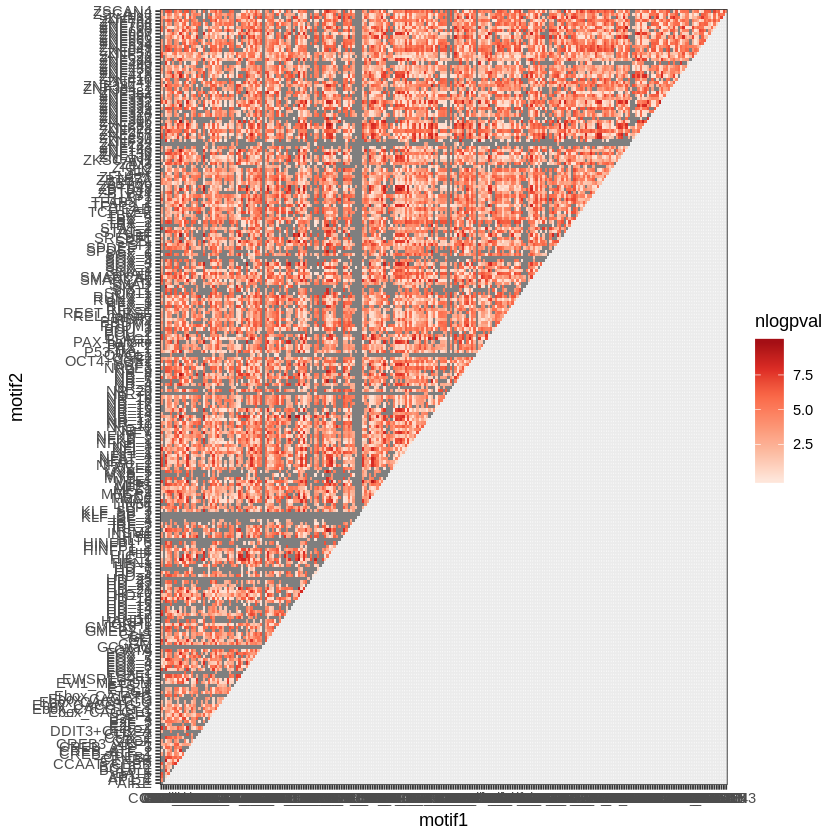

In [190]:
gpt = ggplot(tmp, aes(x=motif1, y=motif2, fill=nlogpval)) + 
    geom_tile() + 
    theme_bw() +
    scale_fill_distiller(palette="Reds", direction=1)

print(gpt)

In [286]:
mat = tmp %>% dplyr::select(motif1, motif2, nlogpval) %>% spread(motif2, nlogpval)
mat = column_to_rownames(mat, var = "motif1")

idx = colnames(mat)
mat = mat[idx,]
mat[is.na(mat)] = 0
mat = mat + t(mat)

In [287]:
head(mat)

,AIRE,AP1_1,AP1_2,BATF,BCL6_1,BCL6_2,CCAAT_CEBP,CENBP,CPEB1,CREB_ATF_1,...,ZNF563,ZNF586,ZNF667,ZNF680,ZNF708,ZNF768,ZNF784,ZNF85,ZSCAN3,ZSCAN4
AIRE,0,0.0000000,0.0000000,0.000000,0.000000,0.000000,0.0000000,0.0000000,0.000000,0.0000000,...,0.0000000,0.00000000,0.0000000,0.0000000,0.00000000,0.000000,0.000000,3.7325615,0.0000000,0.000000
AP1_1,0,0.0000000,0.7244424,1.854083,7.313369,4.565877,0.8507869,8.7828759,6.472166,1.3296863,...,0.6767056,2.66707652,0.3089793,0.7364335,3.95298965,1.001518,5.628444,0.6607238,1.0547094,6.505452
AP1_2,0,0.7244424,0.0000000,5.730547,1.184637,1.996663,3.3481021,0.3936008,7.010027,5.3694026,...,4.9122528,3.86203578,2.1188677,6.6917014,0.62654336,4.828802,6.701888,3.7296387,5.1730138,7.028334
BATF,0,1.8540829,5.7305471,0.000000,0.000000,0.857203,2.9141117,1.4865572,6.896038,3.8176529,...,4.2304824,5.43365531,3.6351526,5.6495175,0.28380796,3.727598,6.047150,2.4538357,3.9624437,6.429455
BCL6_1,0,7.3133692,1.1846368,0.000000,0.000000,0.000000,6.4442775,4.9470688,5.395585,0.2992844,...,0.0000000,2.45402602,6.2005668,0.0000000,0.04187784,0.000000,0.000000,0.6660023,0.2308226,0.000000
BCL6_2,0,4.5658769,1.9966634,0.857203,0.000000,0.000000,7.4919886,0.8616267,6.056143,4.4596926,...,4.4201566,0.08254352,3.0922135,3.7309812,2.01261574,3.799941,5.820607,3.5906706,4.3471710,5.699514


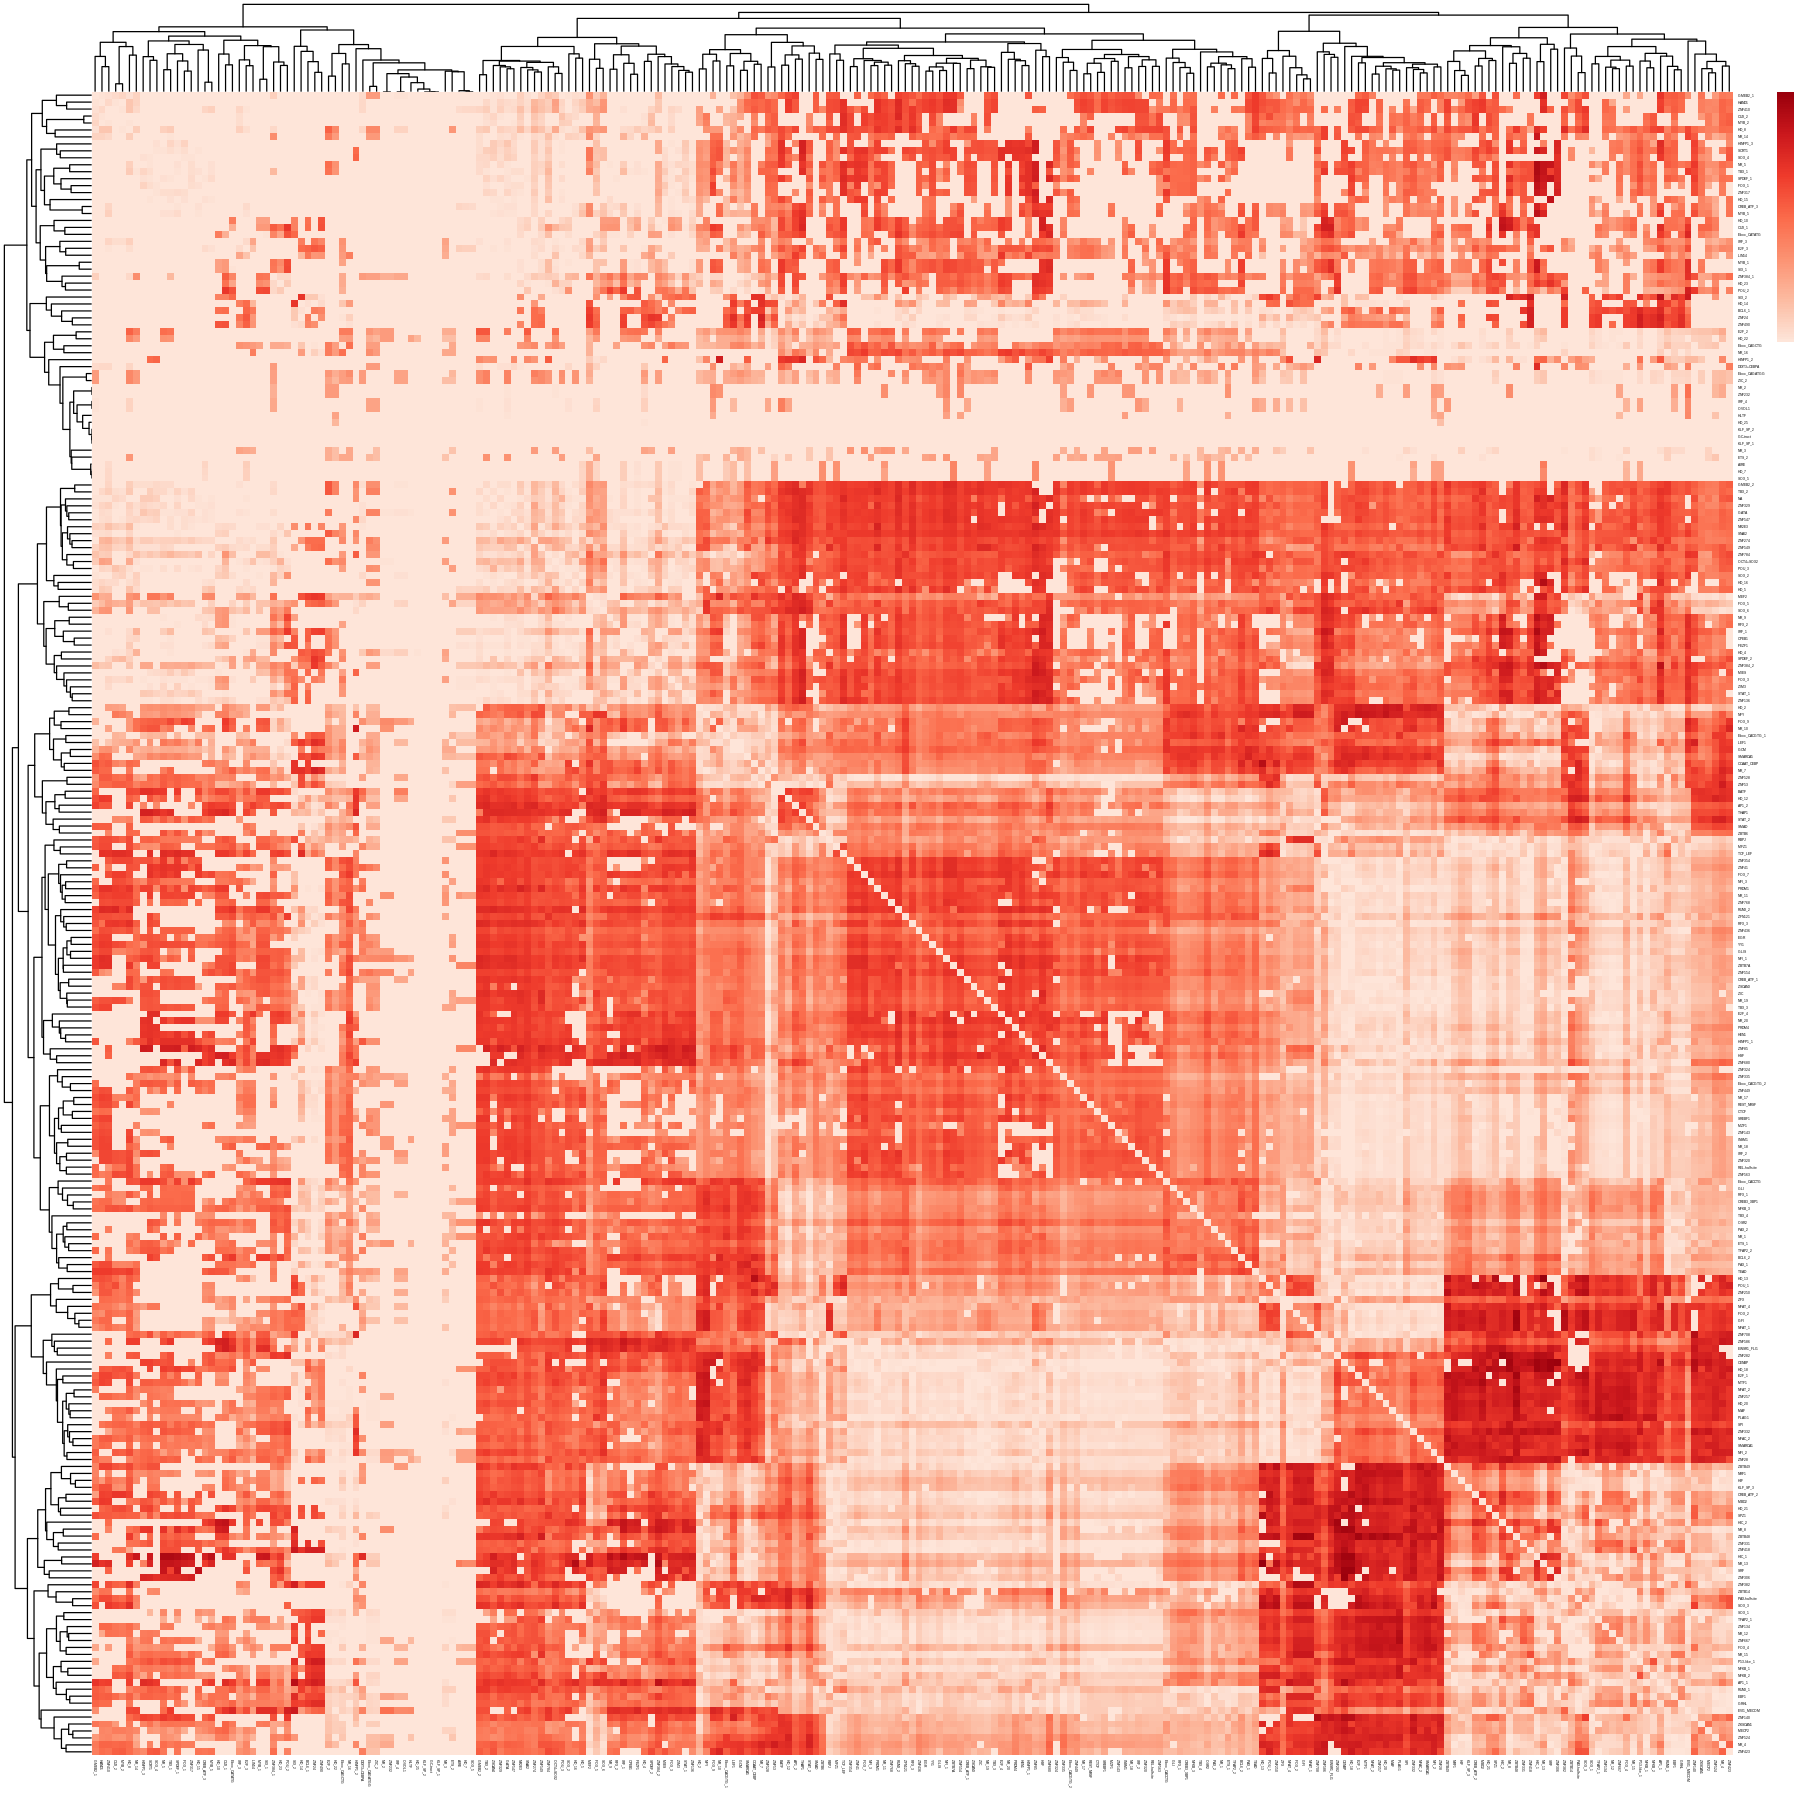

In [289]:
options(repr.plot.width=15, repr.plot.height=15)
out = pheatmap(
    mat, 
    fontsize = 2,
    color = colorRampPalette(brewer.pal(n = 7, name="Reds"))(100))

In [270]:
idx = apply(mat, 1, mean)
idx = (idx > 3)
mat = mat[idx, idx]

In [271]:
head(mat)

,AP1_1,AP1_2,BATF,BCL6_2,CCAAT_CEBP,CREB_ATF_1,CREB_ATF_2,CREB3_XBP1,E2F_1,Ebox_CACCTG,...,ZNF547,ZNF549,ZNF554,ZNF586,ZNF680,ZNF768,ZNF784,ZNF85,ZSCAN3,ZSCAN4
AP1_1,0.0000000,0.7244424,1.854083,4.565877,0.8507869,1.329686,0.4395621,4.419340,6.8864883,3.907237,...,6.732826,7.198402,0.945162,2.66707652,0.7364335,1.001518,5.628444,0.6607238,1.054709,6.505452
AP1_2,0.7244424,0.0000000,5.730547,1.996663,3.3481021,5.369403,2.8399468,2.132354,1.3792574,3.741573,...,7.374258,6.477794,4.848100,3.86203578,6.6917014,4.828802,6.701888,3.7296387,5.173014,7.028334
BATF,1.8540829,5.7305471,0.000000,0.857203,2.9141117,3.817653,4.9018438,0.630246,3.2693519,1.717718,...,6.305776,5.600481,4.160478,5.43365531,5.6495175,3.727598,6.047150,2.4538357,3.962444,6.429455
BCL6_2,4.5658769,1.9966634,0.857203,0.000000,7.4919886,4.459693,4.1236513,6.080682,2.7057383,5.226724,...,5.939018,5.370879,4.544422,0.08254352,3.7309812,3.799941,5.820607,3.5906706,4.347171,5.699514
CCAAT_CEBP,0.8507869,3.3481021,2.914112,7.491989,0.0000000,3.602737,1.1658600,6.438906,6.5502763,5.915147,...,4.299662,2.606250,3.655740,3.84905793,4.2094043,3.577139,2.316865,5.2505822,3.329914,3.372572
CREB_ATF_1,1.3296863,5.3694026,3.817653,4.459693,3.6027367,0.000000,0.0000000,3.401546,0.1390603,5.588957,...,6.912766,6.589304,6.470119,1.95057502,6.1230749,6.185543,5.688451,6.1305787,5.796292,6.502364


In [272]:
dim(mat)

[1] 102 102

In [273]:
which(colnames(mat) == "NR_20")

[1] 49

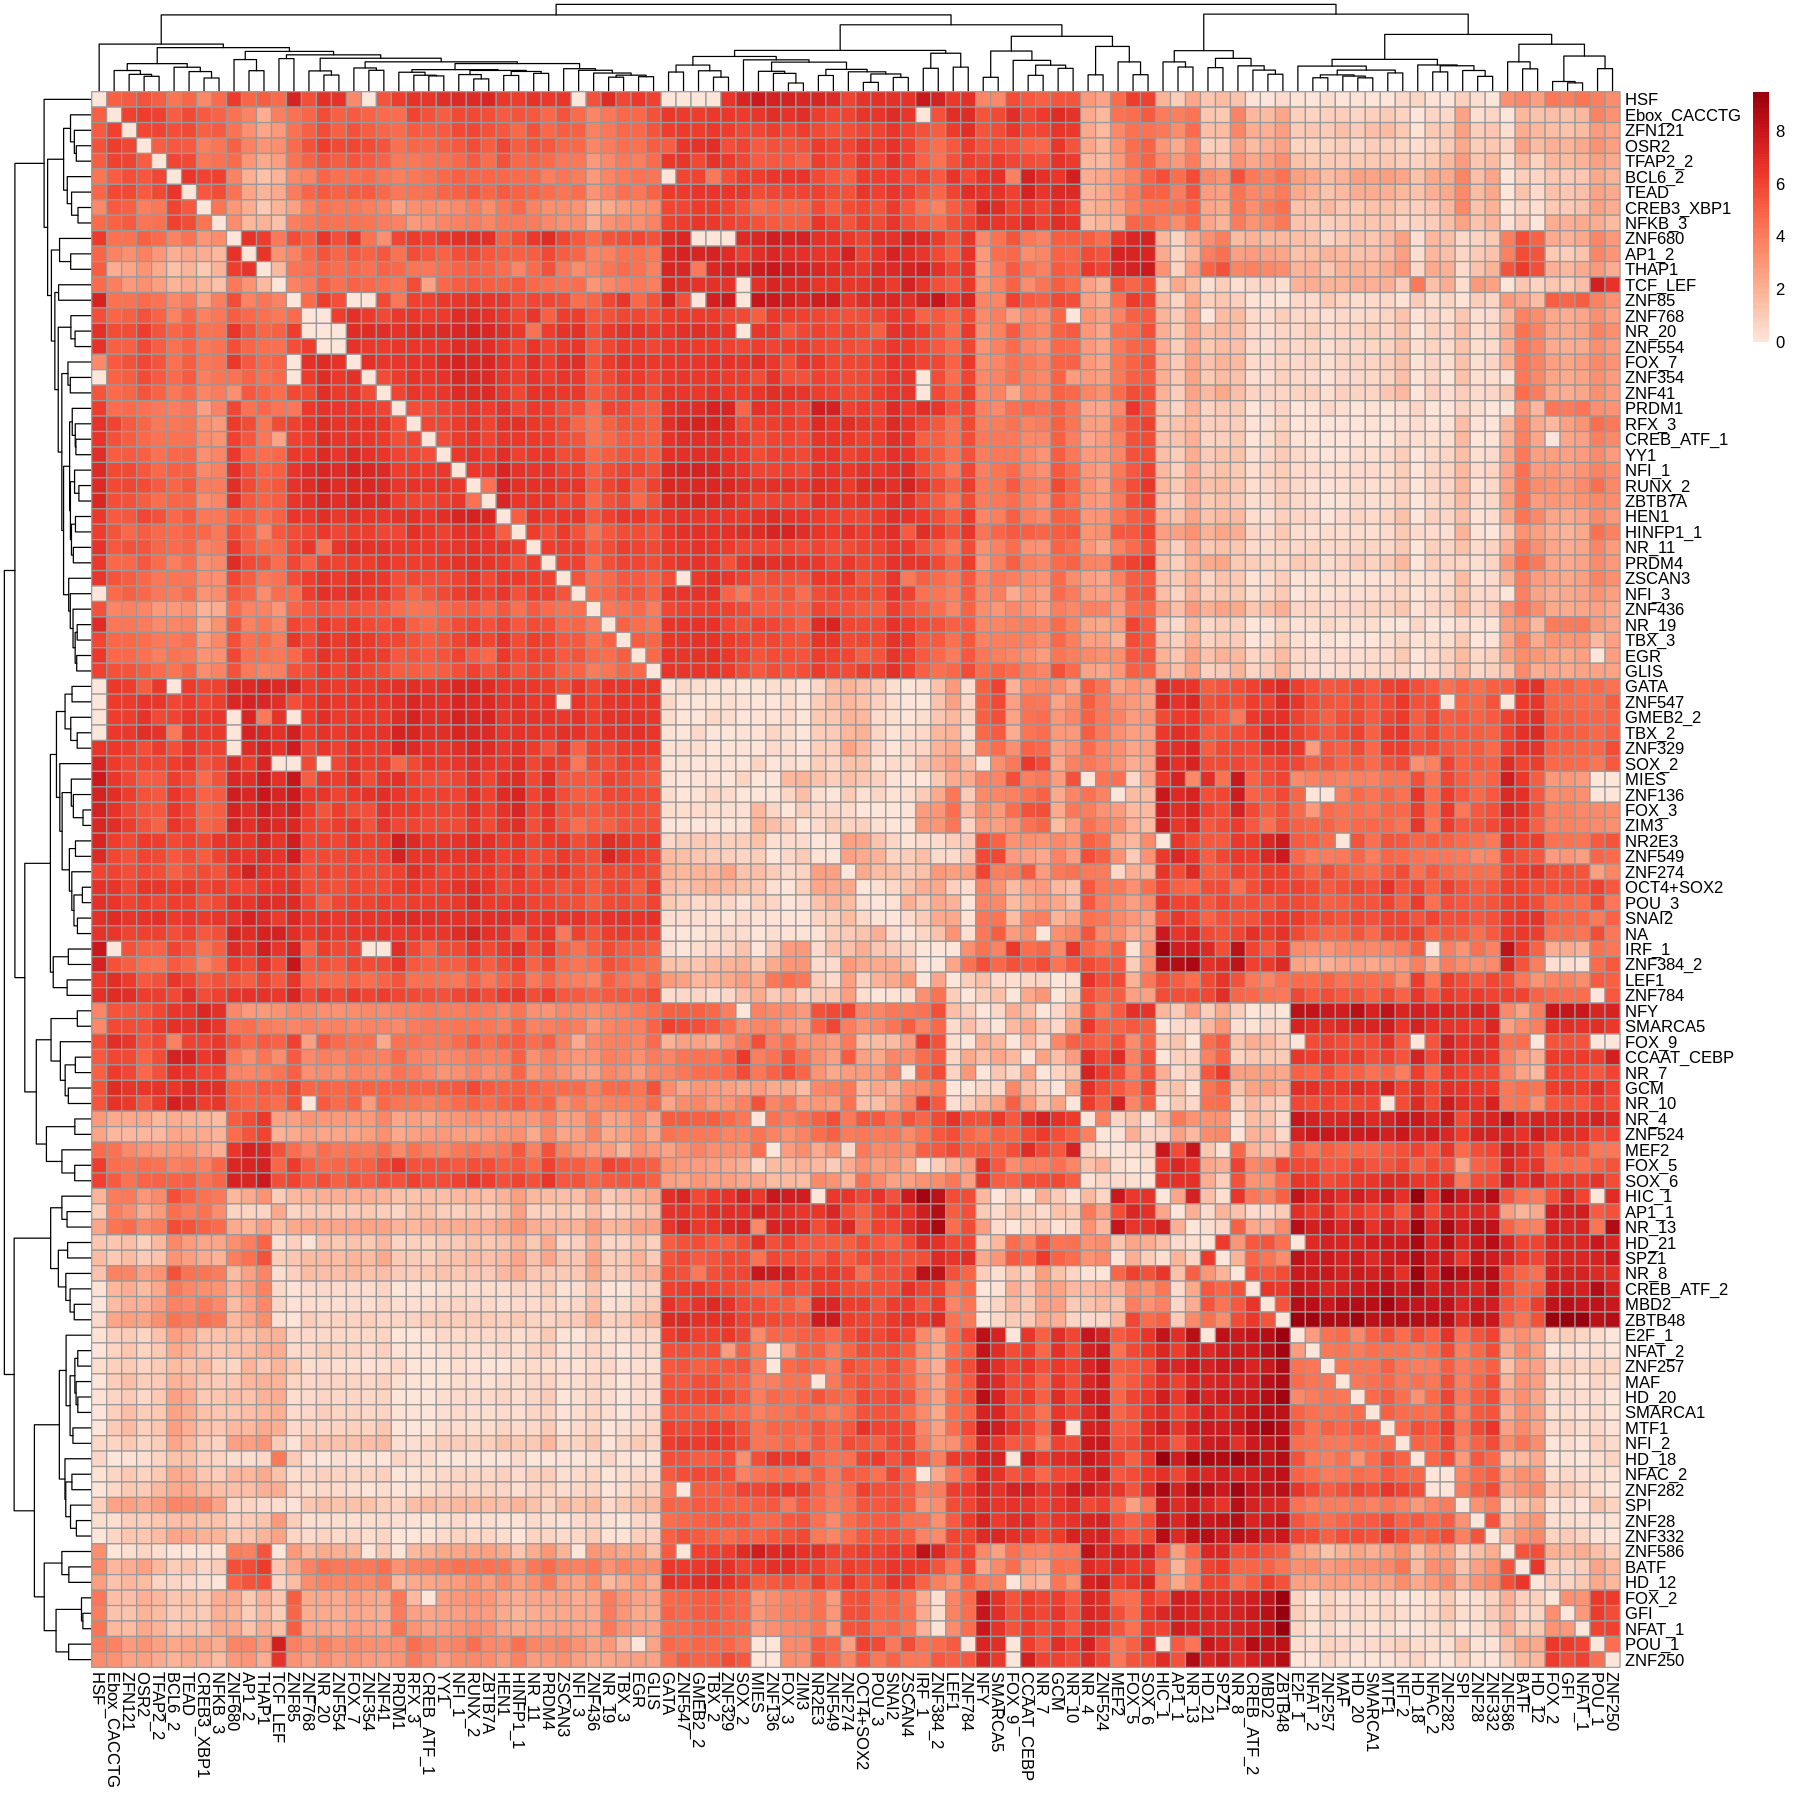

In [274]:
options(repr.plot.width=15, repr.plot.height=15)
out = pheatmap(
    mat, 
    fontsize = 10,
    color = colorRampPalette(brewer.pal(n = 7, name="Reds"))(100))

In [277]:
idx = rownames(mat[out$tree_row[["order"]],])

In [280]:
mat["NR_20", out$tree_col[["order"]]]

,HSF,Ebox_CACCTG,ZFN121,OSR2,TFAP2_2,BCL6_2,TEAD,CREB3_XBP1,NFKB_3,ZNF680,...,ZNF28,ZNF332,ZNF586,BATF,HD_12,FOX_2,GFI,NFAT_1,POU_1,ZNF250
NR_20,6.820394,5.709039,5.792882,6.19276,5.511888,4.898409,5.270638,4.387853,4.521656,6.629443,...,0.3267223,0.7600983,2.214853,4.458731,3.806213,2.434293,2.188386,2.473969,3.825027,3.29631


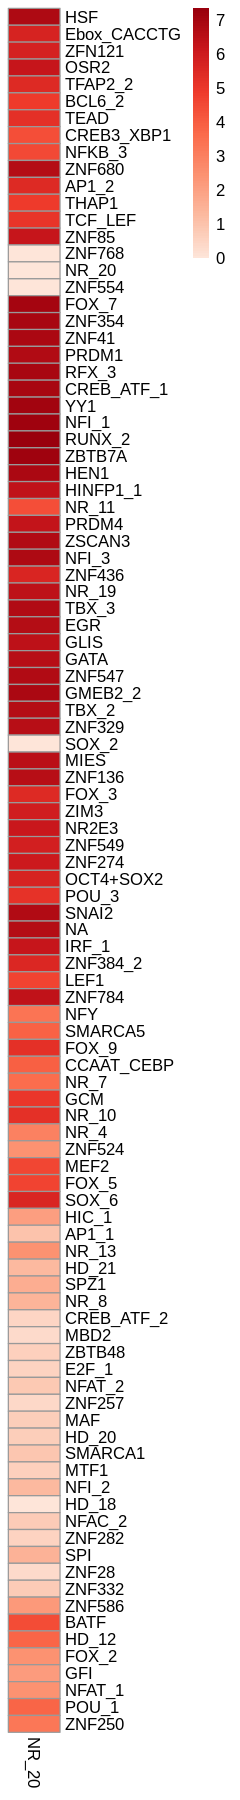

In [285]:
options(repr.plot.width=2, repr.plot.height=15)
pheatmap(mat[out$tree_row[["order"]], "NR_20", drop=FALSE], 
         cluster_cols = FALSE, cluster_rows = FALSE,
         fontsize = 10,
         color = colorRampPalette(brewer.pal(n = 7, name="Reds"))(100))

In [201]:
mat = tmp %>% dplyr::select(motif1, motif2, nlogpval)
head(mat)

motif1,motif2,nlogpval
AHR,AIRE,NA
AHR,AP1_1,4.551739
AHR,AP1_2,6.225850
AHR,BATF,6.767616
AHR,BCL6_1,NA
AHR,BCL6_2,2.550767


In [200]:
mat = tmp %>% dplyr::select(motif1, motif2, nlogpval)
rplot(mat)

ERROR: Error in as_cordf(rdf): Input object x is not a square. The number of columns must be equal to the number of rows.


In [199]:
library(corrr)

In [218]:
library(pheatmap)
library(RColorBrewer)

In [198]:
pheatmap(mat)

ERROR: Error in hclust(d, method = method): NA/NaN/Inf in foreign function call (arg 10)


In [195]:
any(is.infinite(mat))

ERROR: Error in is.infinite(mat): default method not implemented for type 'list'


In [ ]:
"AHR"        "CREB_ATF_1"

In [148]:
mtf1 = "AHR"
mtf2 = "CREB_ATF_1"

df1 = lst_frag[[mtf1]]
df2 = lst_frag[[mtf2]]

print(c(mtf1, mtf2))

[1] "AHR"        "CREB_ATF_1"


In [149]:
dat1 = bind_rows(df1, df2) %>% 
    dplyr::select(Chrom_Frag, Start_Frag, End_Frag, Count_Frag, Sample) %>%
    distinct

dat2 = df1 %>% 
    dplyr::select(Chrom_Frag, Start_Frag, End_Frag, Count_Frag, Sample, Motif)

dat3 = df2 %>% 
    dplyr::select(Chrom_Frag, Start_Frag, End_Frag, Count_Frag, Sample, Motif)

In [150]:
dat = dat1 %>%
    full_join(dat2, by = c("Chrom_Frag", "Start_Frag", "End_Frag", "Count_Frag", "Sample")) %>%
    full_join(dat3, by = c("Chrom_Frag", "Start_Frag", "End_Frag", "Count_Frag", "Sample")) %>%
    mutate(Motif = paste(Motif.x, Motif.y, sep = "_")) %>%
    mutate(Motif = str_remove(string=Motif, pattern="_NA|NA_")) %>% 
    mutate(Group = str_remove(string = Sample, pattern = "[0-9]")) %>%
    mutate(X     = paste(Group, Motif, sep="_")) %>%
    mutate(X     = ifelse(str_detect(X, "Input"), "Input", X))
head(dat)

Chrom_Frag,Start_Frag,End_Frag,Count_Frag,Sample,Motif.x,Motif.y,Motif,Group,X
chr17,8150329,8151343,1,Input1,AHR,CREB_ATF/1,AHR_CREB_ATF/1,Input,Input
chr17,8150402,8151376,1,Input1,AHR,CREB_ATF/1,AHR_CREB_ATF/1,Input,Input
chr17,8150410,8151356,1,Input1,AHR,CREB_ATF/1,AHR_CREB_ATF/1,Input,Input
chr17,8150421,8151368,1,Input1,AHR,CREB_ATF/1,AHR_CREB_ATF/1,Input,Input
chr17,8150585,8151628,1,Input1,AHR,CREB_ATF/1,AHR_CREB_ATF/1,Input,Input
chr17,8150681,8151651,1,Input1,AHR,CREB_ATF/1,AHR_CREB_ATF/1,Input,Input


In [151]:
tmp = dat %>% group_by(Sample, X) %>% summarize(Value = sum(Count_Frag))
tmp

`summarise()` has grouped output by 'Sample'. You can override using the `.groups` argument.


Sample,X,Value
Input1,Input,110
Input2,Input,140
Input3,Input,171
Input4,Input,122
Input5,Input,81
TFX2_Dex,TFX_Dex_AHR,9
TFX2_Dex,TFX_Dex_AHR_CREB_ATF/1,783
TFX2_Dex,TFX_Dex_CREB_ATF/1,1509
TFX2_DMSO,TFX_DMSO_AHR,8
TFX2_DMSO,TFX_DMSO_AHR_CREB_ATF/1,378


In [152]:
unique(tmp$X)

[1] "Input"                   "TFX_Dex_AHR"            
[3] "TFX_Dex_AHR_CREB_ATF/1"  "TFX_Dex_CREB_ATF/1"     
[5] "TFX_DMSO_AHR"            "TFX_DMSO_AHR_CREB_ATF/1"
[7] "TFX_DMSO_CREB_ATF/1"

In [153]:
idx11 = paste("XTFX_DMSO", mtf1, sep="_")
idx12 = paste("XTFX_DMSO", mtf2, sep="_")
idx13 = paste("XTFX_DMSO", mtf1, mtf2, sep="_")

idx21 = paste("XTFX_Dex", mtf1, sep="_")
idx22 = paste("XTFX_Dex", mtf2, sep="_")
idx23 = paste("XTFX_Dex", mtf1, mtf2, sep="_")

In [154]:
c("Input", idx11, idx12, idx13, idx21, idx22, idx23)

[1] "Input"                    "XTFX_DMSO_AHR"           
[3] "XTFX_DMSO_CREB_ATF_1"     "XTFX_DMSO_AHR_CREB_ATF_1"
[5] "XTFX_Dex_AHR"             "XTFX_Dex_CREB_ATF_1"     
[7] "XTFX_Dex_AHR_CREB_ATF_1"

In [59]:
X = model.matrix(~X, tmp)
X[,idx11] = X[,idx11] + X[,idx13] + X[,idx21] + X[,idx23]
X[,idx12] = X[,idx12] + X[,idx13] + X[,idx22] + X[,idx23]
X[,idx21] = X[,idx21] + X[,idx23]
X[,idx22] = X[,idx22] + X[,idx23]
X[,idx13] = X[,idx13] + X[,idx23]

In [60]:
fit = lm(y ~ X + 0)
res = summary(fit)
print(res)


Call:
lm(formula = y ~ X + 0)

Residuals:
    Min      1Q  Median      3Q     Max 
-367.00  -33.50    4.25   40.25  401.00 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
X(Intercept)             142.40      61.30   2.323   0.0298 *  
XXTFX_Dex_AP1_1          -18.75      96.92  -0.193   0.8484    
XXTFX_Dex_NR_20          930.50      96.92   9.600 2.52e-09 ***
XXTFX_Dex_NR_20_AP1_1   -285.25     167.88  -1.699   0.1034    
XXTFX_DMSO_AP1_1           2.10      91.95   0.023   0.9820    
XXTFX_DMSO_NR_20          85.10      91.95   0.925   0.3648    
XXTFX_DMSO_NR_20_AP1_1   -73.85     133.60  -0.553   0.5860    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 137.1 on 22 degrees of freedom
Multiple R-squared:  0.9529,	Adjusted R-squared:  0.9379 
F-statistic: 63.59 on 7 and 22 DF,  p-value: 3.94e-13



In [ ]:
X = model.matrix(~X, tmp)
X[,"XTFX_DMSO_AP1_1"] = X[,"XTFX_DMSO_AP1_1"] + X[,"XTFX_DMSO_NR_20_AP1_1"] + X[,"XTFX_Dex_AP1_1"] + X[,"XTFX_Dex_NR_20_AP1_1"]
X[,"XTFX_DMSO_NR_20"] = X[,"XTFX_DMSO_NR_20"] + X[,"XTFX_DMSO_NR_20_AP1_1"] + X[,"XTFX_Dex_NR_20"] + X[,"XTFX_Dex_NR_20_AP1_1"]
X[,"XTFX_Dex_AP1_1"]  = X[,"XTFX_Dex_AP1_1"] + X[,"XTFX_Dex_NR_20_AP1_1"]
X[,"XTFX_Dex_NR_20"]  = X[,"XTFX_Dex_NR_20"] + X[,"XTFX_Dex_NR_20_AP1_1"]
X[,"XTFX_DMSO_NR_20_AP1_1"] = X[,"XTFX_DMSO_NR_20_AP1_1"] + X[,"XTFX_Dex_NR_20_AP1_1"]


In [32]:
X = model.matrix(~X, tmp)
X[,idx11] = X[,idx11] + X[,idx12] + X[,idx31] + X[,idx31]
X[,idx21] = X[,idx21] + X[,idx22]
X = data.frame(X)
X$X = tmp$X
X

X.Intercept.,XTFX_Dex_AP1_1,XTFX_Dex_NR_20,XTFX_Dex_NR_20_AP1_1,XTFX_DMSO_AP1_1,XTFX_DMSO_NR_20,XTFX_DMSO_NR_20_AP1_1,X
1,0,0,0,0,0,0,Input
1,0,0,0,0,0,0,Input
1,0,0,0,0,0,0,Input
1,0,0,0,0,0,0,Input
1,0,0,0,0,0,0,Input
1,1,0,0,1,0,0,TFX_Dex_AP1_1
1,0,1,0,0,1,0,TFX_Dex_NR_20
1,0,0,1,0,0,0,TFX_Dex_NR_20_AP1_1
1,0,0,0,1,0,0,TFX_DMSO_AP1_1
1,0,0,0,0,1,0,TFX_DMSO_NR_20


In [38]:
X = model.matrix(~X, tmp)

X[,"XTFX_DMSO_AP1_1"] = X[,"XTFX_DMSO_AP1_1"] + X[,"XTFX_DMSO_NR_20_AP1_1"] + X[,"XTFX_Dex_AP1_1"] + X[,"XTFX_Dex_NR_20_AP1_1"]
X[,"XTFX_DMSO_NR_20"] = X[,"XTFX_DMSO_NR_20"] + X[,"XTFX_DMSO_NR_20_AP1_1"] + X[,"XTFX_Dex_NR_20"] + X[,"XTFX_Dex_NR_20_AP1_1"]

X[,"XTFX_Dex_AP1_1"] = X[,"XTFX_Dex_AP1_1"] + X[,"XTFX_Dex_NR_20_AP1_1"]
X[,"XTFX_Dex_NR_20"] = X[,"XTFX_Dex_NR_20"] + X[,"XTFX_Dex_NR_20_AP1_1"]

X[,"XTFX_DMSO_NR_20_AP1_1"] = X[,"XTFX_DMSO_NR_20_AP1_1"] + X[,"XTFX_Dex_NR_20_AP1_1"]


X = data.frame(X)
X$X = tmp$X
X

X.Intercept.,XTFX_Dex_AP1_1,XTFX_Dex_NR_20,XTFX_Dex_NR_20_AP1_1,XTFX_DMSO_AP1_1,XTFX_DMSO_NR_20,XTFX_DMSO_NR_20_AP1_1,X
1,0,0,0,0,0,0,Input
1,0,0,0,0,0,0,Input
1,0,0,0,0,0,0,Input
1,0,0,0,0,0,0,Input
1,0,0,0,0,0,0,Input
1,1,0,0,1,0,0,TFX_Dex_AP1_1
1,0,1,0,0,1,0,TFX_Dex_NR_20
1,1,1,1,1,1,1,TFX_Dex_NR_20_AP1_1
1,0,0,0,1,0,0,TFX_DMSO_AP1_1
1,0,0,0,0,1,0,TFX_DMSO_NR_20


In [39]:
X = model.matrix(~X, tmp)
X[,"XTFX_DMSO_AP1_1"] = X[,"XTFX_DMSO_AP1_1"] + X[,"XTFX_DMSO_NR_20_AP1_1"] + X[,"XTFX_Dex_AP1_1"] + X[,"XTFX_Dex_NR_20_AP1_1"]
X[,"XTFX_DMSO_NR_20"] = X[,"XTFX_DMSO_NR_20"] + X[,"XTFX_DMSO_NR_20_AP1_1"] + X[,"XTFX_Dex_NR_20"] + X[,"XTFX_Dex_NR_20_AP1_1"]
X[,"XTFX_Dex_AP1_1"]  = X[,"XTFX_Dex_AP1_1"] + X[,"XTFX_Dex_NR_20_AP1_1"]
X[,"XTFX_Dex_NR_20"]  = X[,"XTFX_Dex_NR_20"] + X[,"XTFX_Dex_NR_20_AP1_1"]
X[,"XTFX_DMSO_NR_20_AP1_1"] = X[,"XTFX_DMSO_NR_20_AP1_1"] + X[,"XTFX_Dex_NR_20_AP1_1"]

y = tmp$Value

In [40]:
fit = lm(y ~ X + 0)
res = summary(fit)

In [41]:
print(res)


Call:
lm(formula = y ~ X + 0)

Residuals:
    Min      1Q  Median      3Q     Max 
-367.00  -33.50    4.25   40.25  401.00 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
X(Intercept)             142.40      61.30   2.323   0.0298 *  
XXTFX_Dex_AP1_1          -18.75      96.92  -0.193   0.8484    
XXTFX_Dex_NR_20          930.50      96.92   9.600 2.52e-09 ***
XXTFX_Dex_NR_20_AP1_1   -285.25     167.88  -1.699   0.1034    
XXTFX_DMSO_AP1_1           2.10      91.95   0.023   0.9820    
XXTFX_DMSO_NR_20          85.10      91.95   0.925   0.3648    
XXTFX_DMSO_NR_20_AP1_1   -73.85     133.60  -0.553   0.5860    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 137.1 on 22 degrees of freedom
Multiple R-squared:  0.9529,	Adjusted R-squared:  0.9379 
F-statistic: 63.59 on 7 and 22 DF,  p-value: 3.94e-13

